In [13]:
import pandas as pd
import torchio as tio
import os
import copy
import torch
import ast
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import cv2
import math

*Find the names with specific diseases*

In [14]:
location_csv = pd.read_csv('./new_location.csv')#, index_col='StudyUID')
PATHOLOGY = 'ACL'
VIEW = 'SAGITTAL'
location_csv_acl = location_csv[~location_csv[PATHOLOGY].isnull()]
# location_csv_acl.head(5)
names = location_csv_acl['StudyUID'].tolist()
print(len(names))

182


*Get the location of the disease for every name*

In [15]:
name = names[0]
location_label = location_csv.loc[location_csv['StudyUID'] == name][PATHOLOGY].tolist()
print(location_label)

root_path = './previous_dataset/Preprocessed_dataset_2'
study_path = os.path.join(root_path, name, f'{VIEW}_PROTON.nii')
img = tio.ScalarImage(study_path)
print(img)

['(-87.55134784730409, -27.722715124162843, 7.086135528293381)']
ScalarImage(shape: (1, 512, 512, 27); spacing: (0.36, 0.36, 3.63); orientation: PIR+; path: "previous_dataset/Preprocessed_dataset_2/1.2.840.113619.6.95.31.0.3.4.1.3096.13.97784/SAGITTAL_PROTON.nii")


In [16]:
physical_location = ast.literal_eval(location_label[0]) # Change the string into tuple
sitk_img = img.as_sitk()
# Get the real coordinate of pixel
pixel_location = sitk_img.TransformPhysicalPointToIndex(physical_location)
print(pixel_location)

(254, 206, 13)


In [35]:
#STD = [1.0] * 6
STD = [6.0, 6.0, 6.0, 6.0, 1.0, 1.0]

# radius = [12,12,1]

# ''' A : numpy.ndarray of shape size*size*size. '''
# pixel_map = copy.deepcopy(img)
# pixel_map_data = torch.zeros_like(pixel_map.data)

# ''' (x0, y0, z0) : coordinates of center of circle inside A. '''
# x0, y0, z0 = pixel_location


# for x in range(x0-radius[0], x0+radius[0]+1):
#     for y in range(y0-radius[1], y0+radius[1]+1):
#         for z in range(z0-radius[2], z0+radius[2]+1):
#             distance = radius[0]-math.sqrt((x0-x)**2+(y0-y)**2)
#             z1 = radius[2]-abs(z0-z)
#             # deb = radius - abs(x0-x) - abs(y0-y) - abs(z0-z) 
#             if distance>=0.0 and z1>=0.0:#(deb)>=0: 
#                 pixel_map_data[0,x,y,z] = 1

# pixel_map.set_data(pixel_map_data.type(torch.float32))
# pixel_map = pixel_map.data

pixel_map = copy.deepcopy(img)
pixel_map_data = torch.zeros_like(pixel_map.data)
pixel_map_data[0, pixel_location[0],
                pixel_location[1], pixel_location[2]] = 1.0
pixel_map.set_data(pixel_map_data.type(torch.float32))
pixel_map = tio.transforms.RandomBlur(
    std=STD)(pixel_map)
pixel_map = pixel_map.data


In [17]:
import cv2
import sys
import os
import torch
import numpy as np
import torch.utils.data

class GenerateHeatmap():
    def __init__(self, output_res, num_parts):
        self.output_res = output_res
        self.num_parts = num_parts
        sigma = self.output_res/64
        self.sigma = sigma
        size = 6*sigma + 3
        x = np.arange(0, size, 1, float)
        y = x[:, np.newaxis]
        x0, y0 = 3*sigma + 1, 3*sigma + 1
        self.g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

    def __call__(self, keypoints):
        hms = np.zeros(shape = (self.num_parts, self.output_res, self.output_res), dtype = np.float32)
        sigma = self.sigma
        for p in keypoints:
            for idx, pt in enumerate(p):
                if pt[0] > 0: 
                    x, y = int(pt[0]), int(pt[1])
                    if x<0 or y<0 or x>=self.output_res or y>=self.output_res:
                        continue
                    ul = int(x - 3*sigma - 1), int(y - 3*sigma - 1)
                    br = int(x + 3*sigma + 2), int(y + 3*sigma + 2)

                    c,d = max(0, -ul[0]), min(br[0], self.output_res) - ul[0]
                    a,b = max(0, -ul[1]), min(br[1], self.output_res) - ul[1]

                    cc,dd = max(0, ul[0]), min(br[0], self.output_res)
                    aa,bb = max(0, ul[1]), min(br[1], self.output_res)
                    hms[idx, aa:bb,cc:dd] = np.maximum(hms[idx, aa:bb,cc:dd], self.g[a:b,c:d])
        return hms

In [13]:
org_img = img.data

In [19]:
# Given a tensor of shape height, width, depth, plot each depth slice in a grid
def plot_slices(tensor, title=None):
	tensor = tensor.squeeze()
	n_slices = tensor.shape[2]
	n_rows = int(n_slices / 4)
	fig, axes = plt.subplots(nrows=n_rows, ncols=4, figsize=(20, 20))
	plt.axis('off')
	for i, ax in enumerate(axes.flatten()):
		if i < n_slices:
			ax.imshow(tensor[:, :, i], cmap='gray')
			ax.set_title(f'Slice {i}')
		else:
			ax.axis('off')
	if title:
		fig.suptitle(title, fontsize=16)
	plt.show()

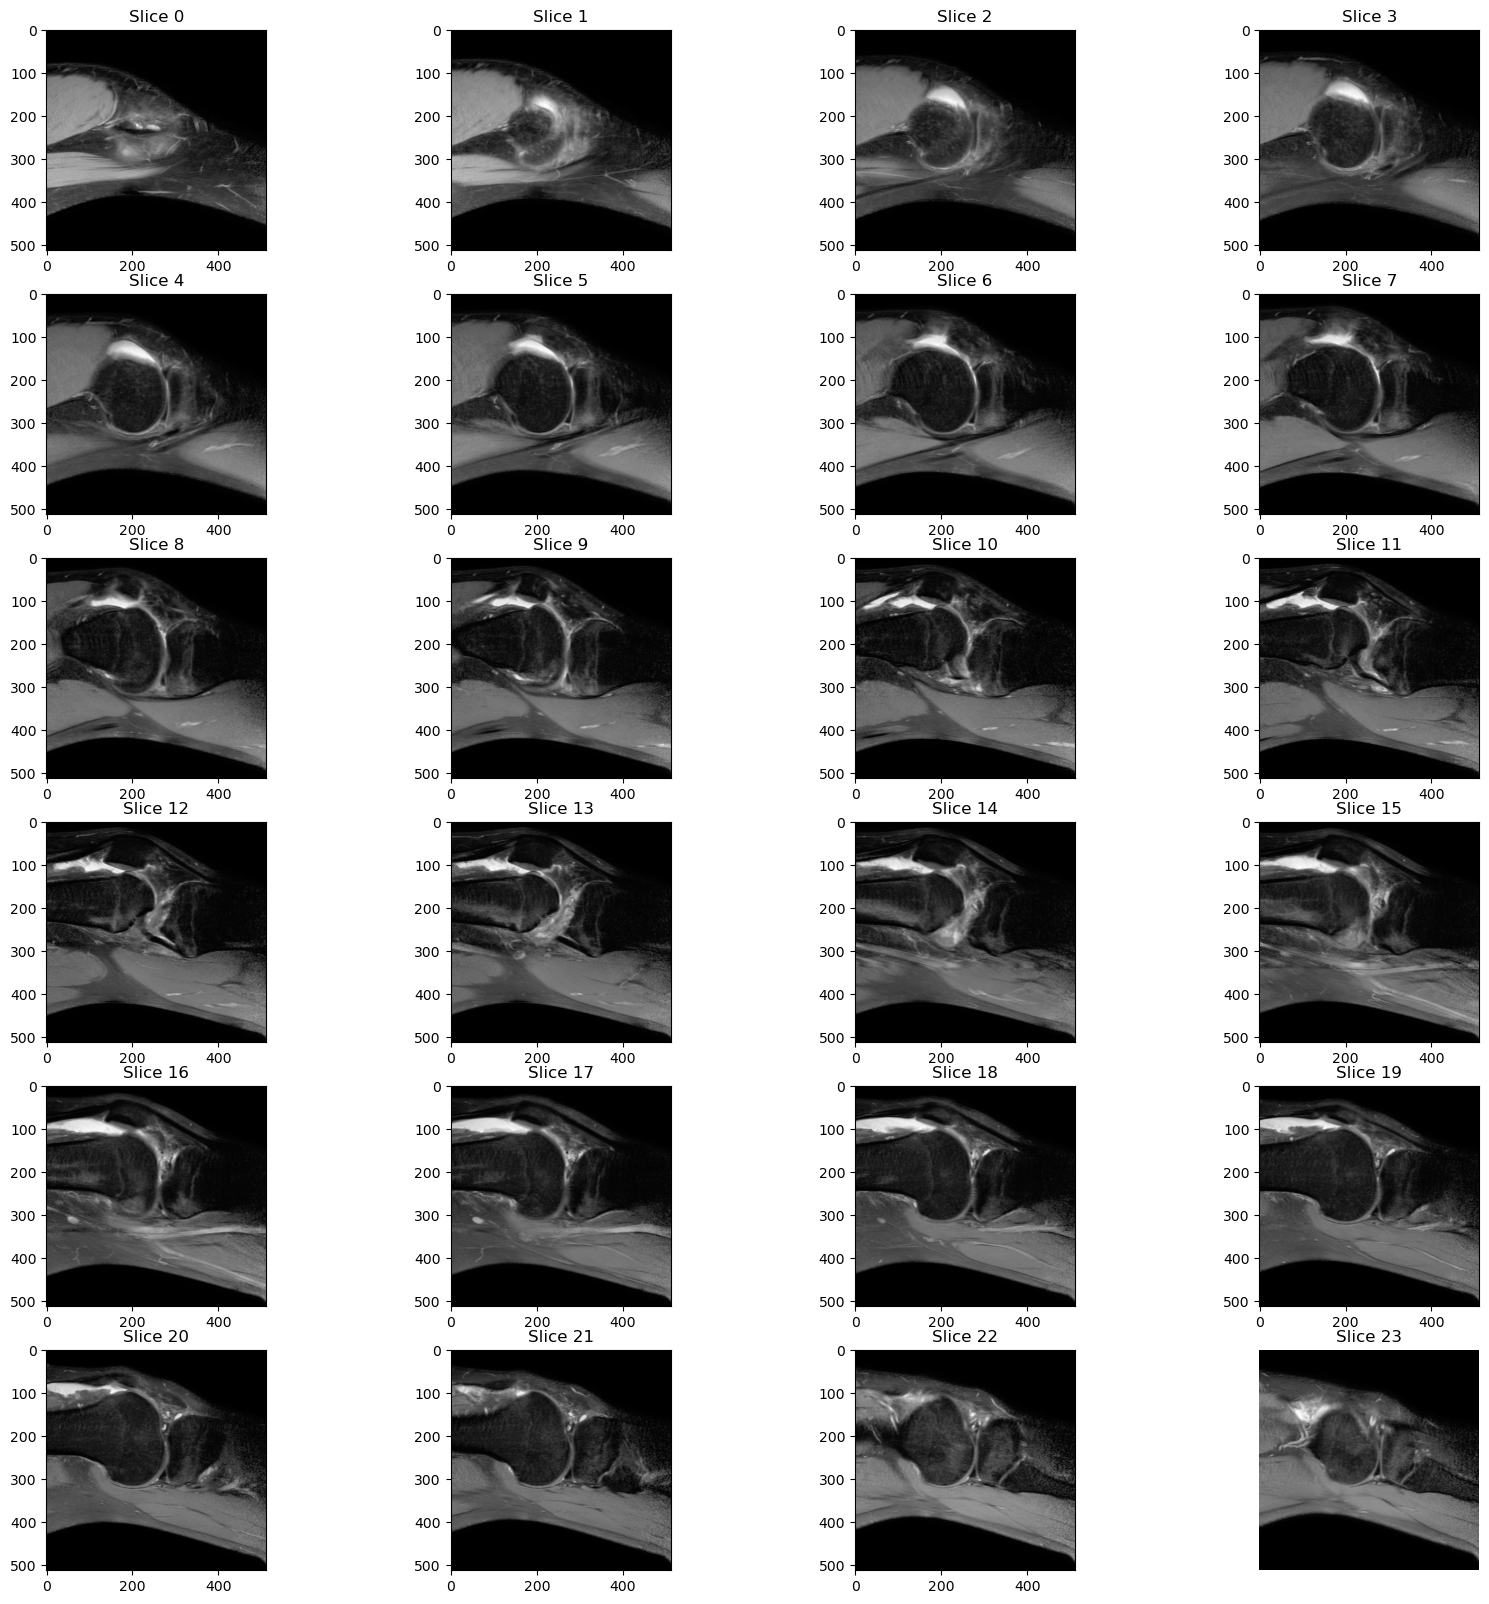

In [15]:
plot_slices(org_img)

In [24]:
import torch
import torch.nn.functional as F

def create_gaussian_ball(tensor_shape, center, radius):
    # Create coordinates grid
    coords = torch.meshgrid(torch.arange(tensor_shape[0]), torch.arange(tensor_shape[1]), torch.arange(tensor_shape[2]))
    coords = torch.stack(coords, dim=-1).float()

    # Compute squared Euclidean distance from the center
    distance = torch.sum(torch.square(coords - center), dim=-1)

    # Create the Gaussian ball
    gaussian_ball = torch.exp(-distance / (2 * radius**2))
    gaussian_ball = F.normalize(gaussian_ball, p=2, dim=(0, 1, 2))  # Normalize to sum up to 1

    return gaussian_ball

# Set tensor shape and ball properties
tensor_shape = (256, 256, 32)
center = torch.tensor([128, 128, 16])  # Center coordinates
radius = 10

# Create the Gaussian ball
gaussian_ball = create_gaussian_ball(tensor_shape, center, radius)

In [43]:
import torch
import torch.nn.functional as F

def create_gaussian_ball(tensor_shape, center, radius, depth_rad=1):
    # Create coordinates grid
    coords = torch.meshgrid(torch.arange(tensor_shape[0]), torch.arange(tensor_shape[1]), torch.arange(tensor_shape[2]))
    coords = torch.stack(coords, dim=-1).float()

    # Compute squared Euclidean distance from the center
    distance = torch.sum(torch.square(coords - center), dim=-1)

    # Create the Gaussian ball
    gaussian_ball = torch.exp(-distance / (2 * radius**2))
    gaussian_ball = F.relu(gaussian_ball)  # Set negative values to zero
    gaussian_ball = F.normalize(gaussian_ball, p=2, dim=(0, 1, 2))  # Normalize to sum up to 1

    # Apply depth range mask
    depth_mask = torch.zeros(tensor_shape[2])
    depth_range = (center[2]-depth_rad,center[2]+depth_rad)
    depth_mask[depth_range[0]:depth_range[1] + 1] = 1
    gaussian_ball *= depth_mask.view(1, 1, -1)

    return gaussian_ball

# Set tensor shape, ball properties, and depth range
tensor_shape = (512, 512, 32)
center = torch.tensor([128, 128, 16])  # Center coordinates
radius = 12

# Create the Gaussian ball with restricted depth range
gaussian_ball = create_gaussian_ball(tensor_shape, center, radius)

count = torch.nonzero(gaussian_ball).size(0)
print(count)

233109


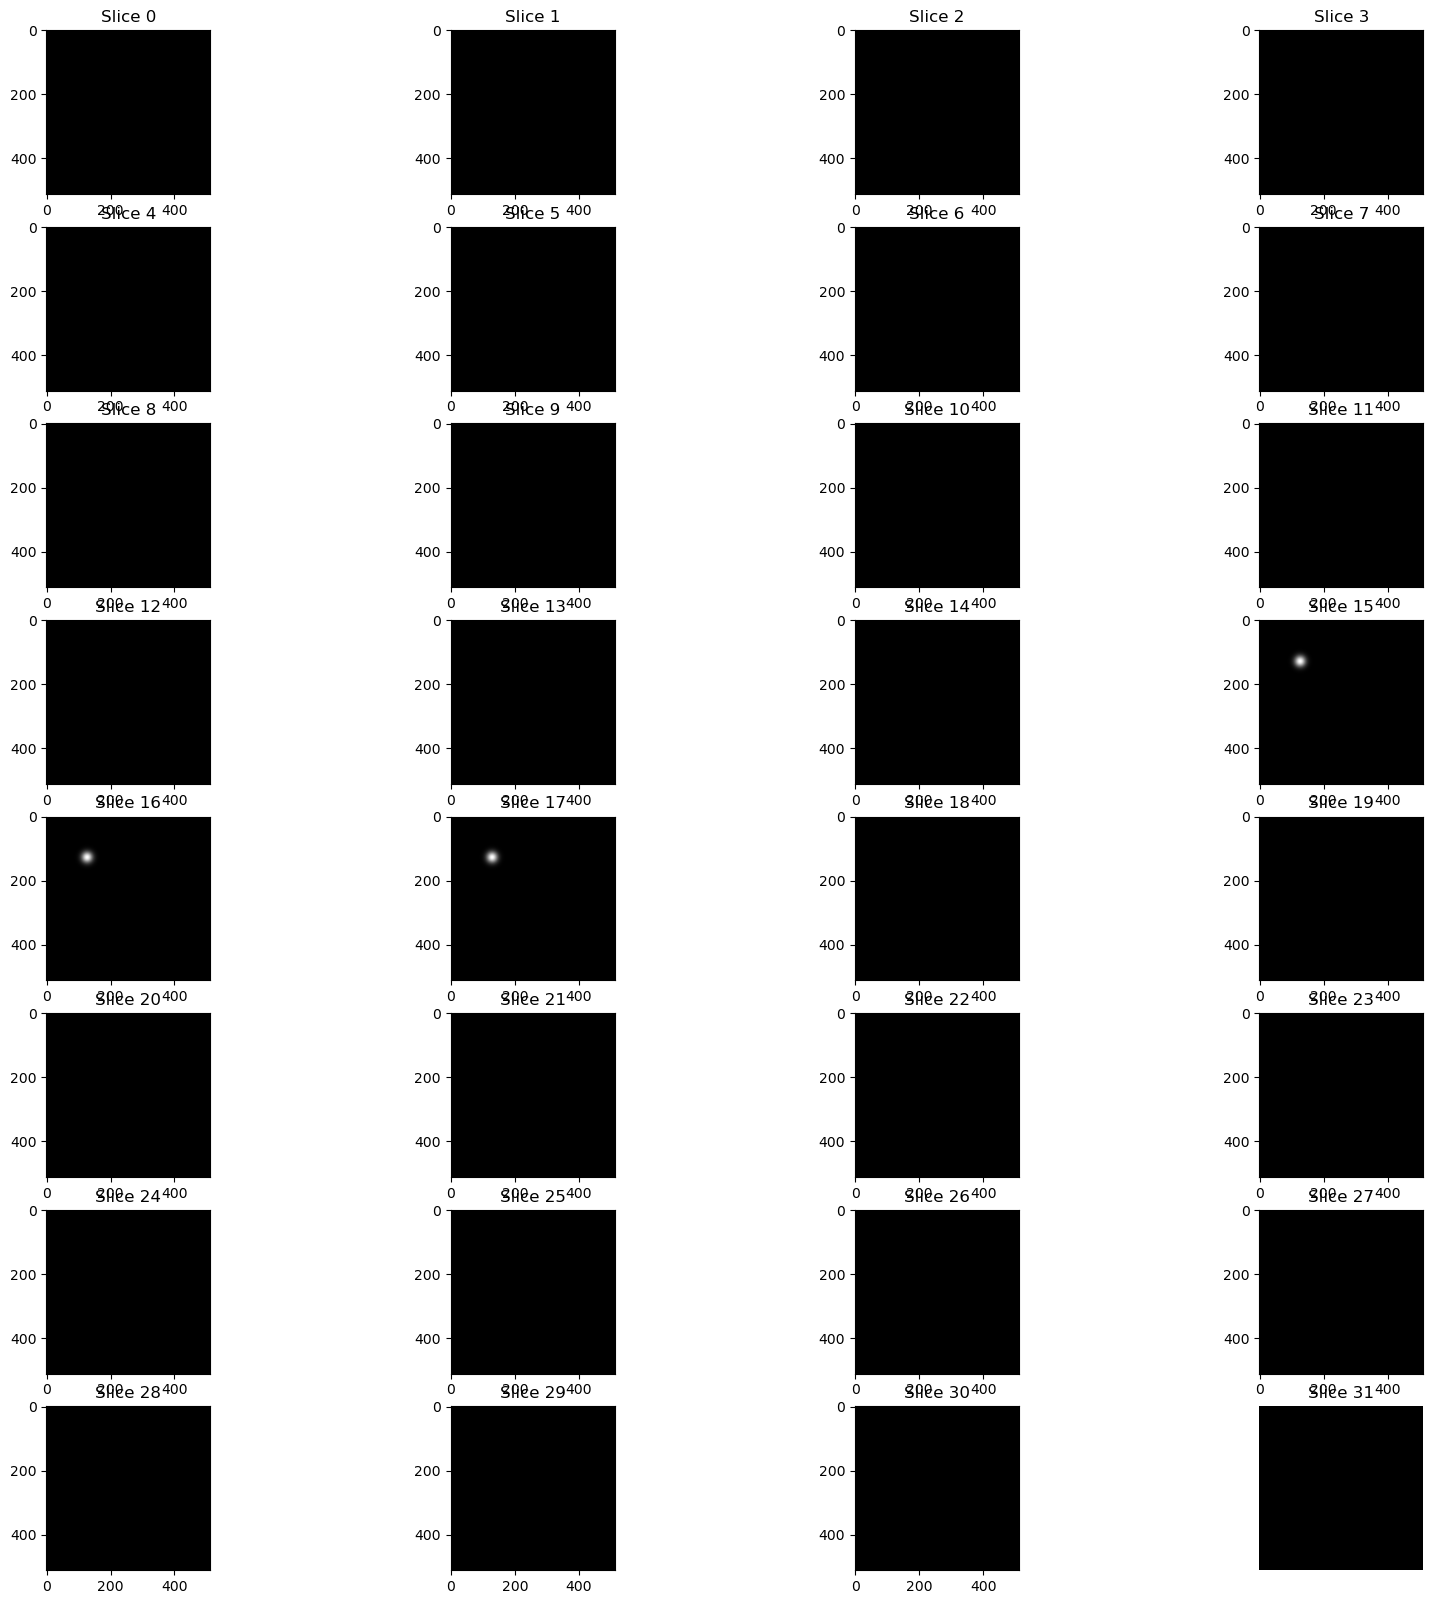

In [32]:
plot_slices(gaussian_ball)

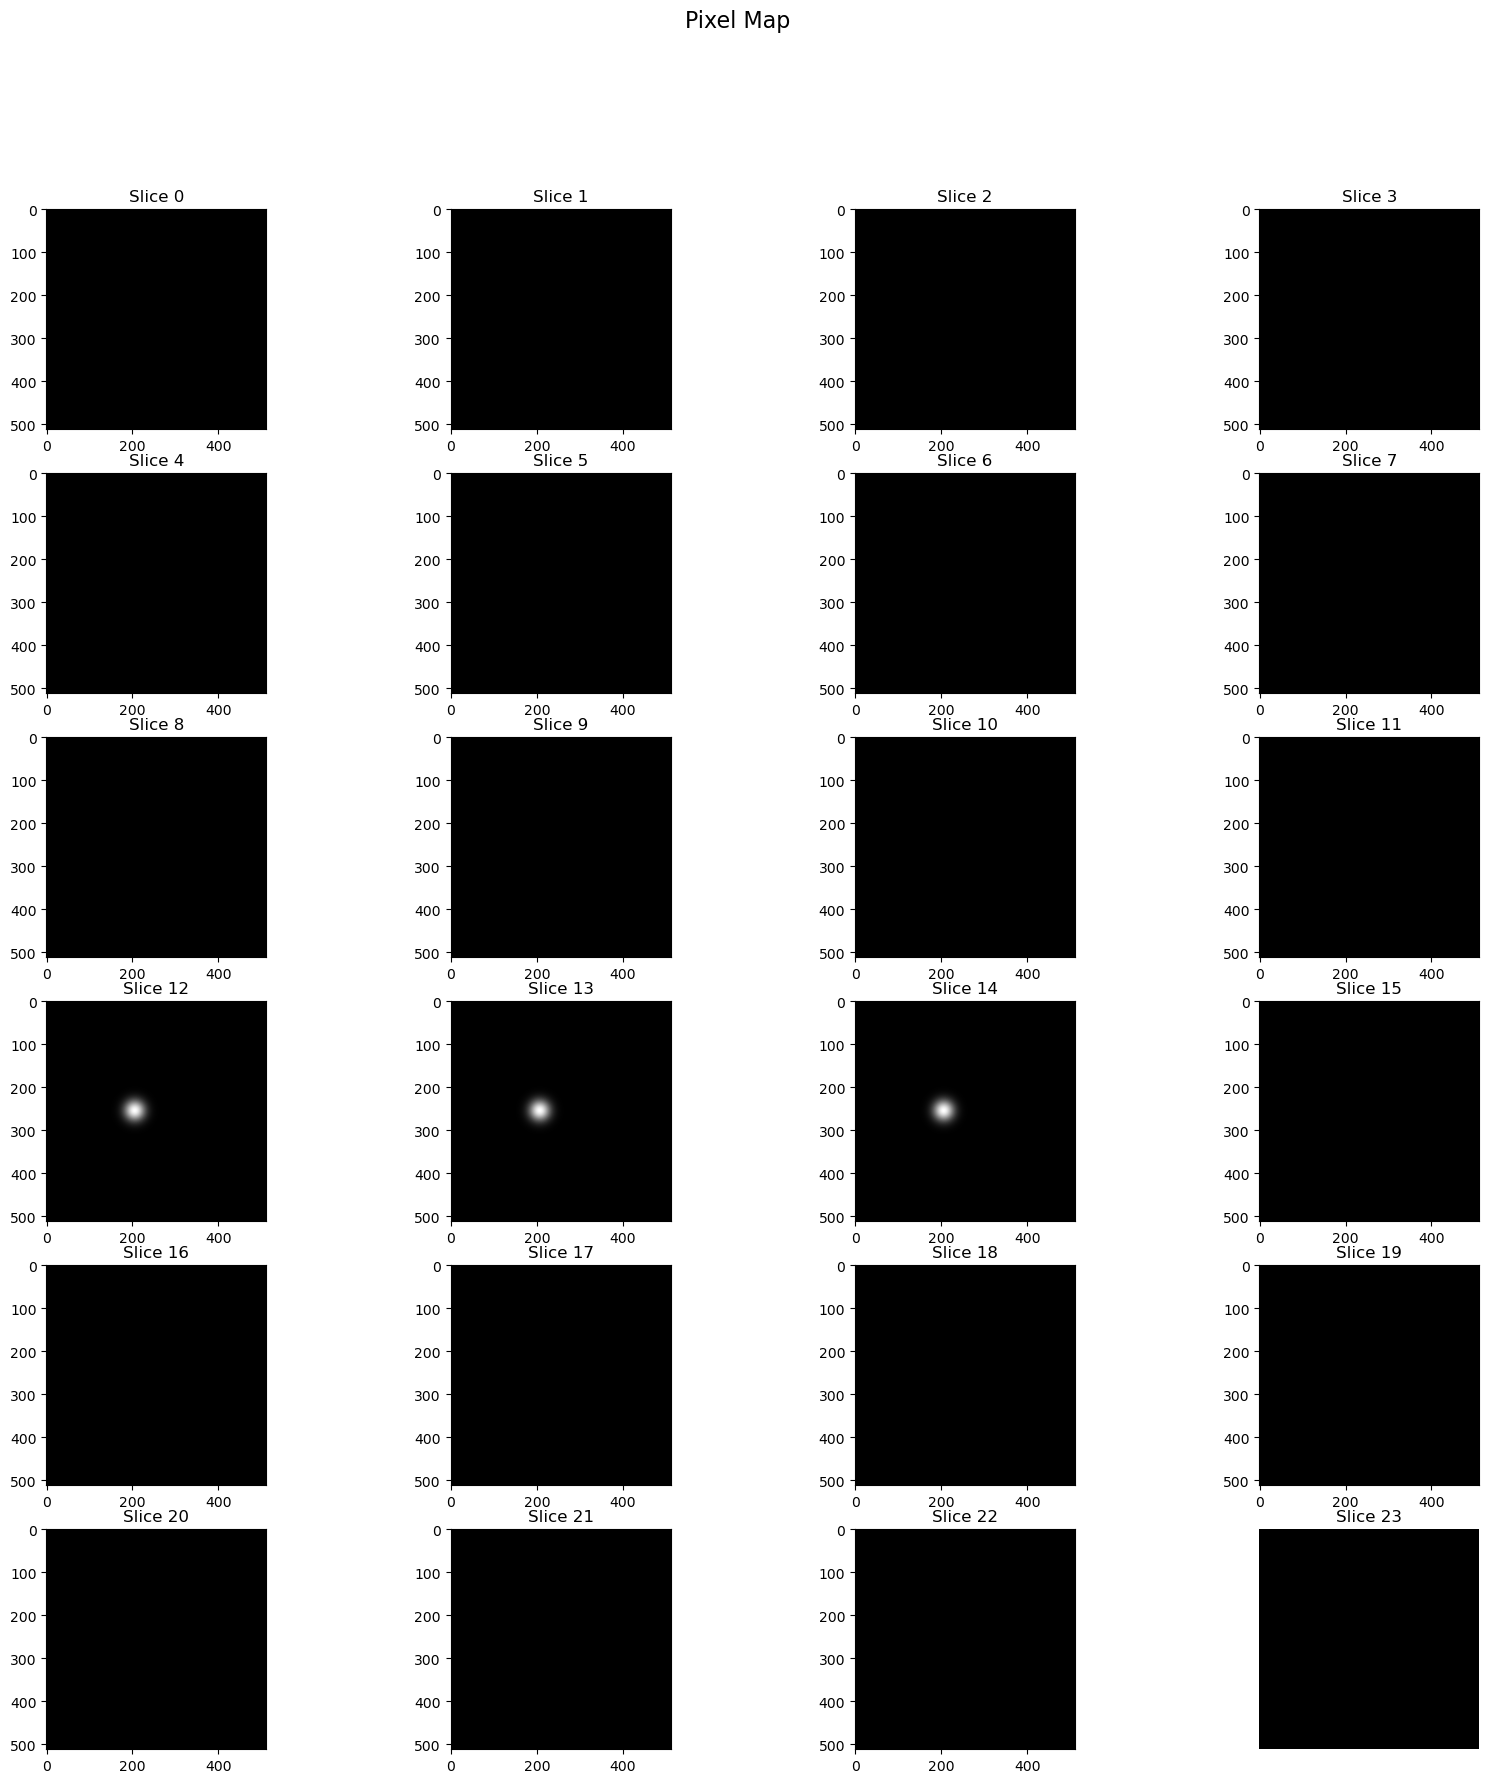

In [36]:
plot_slices(pixel_map.data, title='Pixel Map')

In [10]:
# Find slice with maximal value
def find_max_slice(tensor):
	tensor = tensor.squeeze()
	n_slices = tensor.shape[2]
	max_slice = 0
	max_val = 0
	for i in range(n_slices):
		slice_val = torch.sum(tensor[:, :, i])
		if slice_val > max_val:
			max_val = slice_val
			max_slice = i
	return max_slice

In [11]:
SLICE_IDX = find_max_slice(pixel_map)
print(SLICE_IDX)
org_img_slice = np.rot90(org_img[0, :, :, SLICE_IDX].numpy(), axes=(1,0))
pixel_map_slice = np.rot90(pixel_map[0, :, :, SLICE_IDX].numpy(), axes=(1,0))

20


(-0.5, 511.5, 511.5, -0.5)

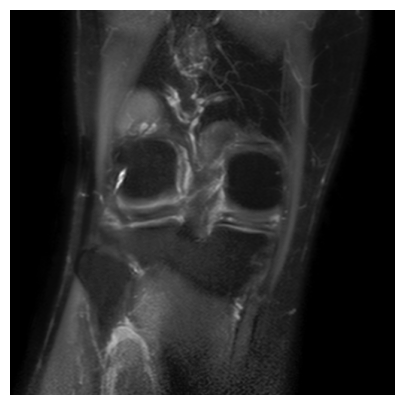

In [12]:
# make the figure bigger
plt.figure(figsize=(5, 5))
plt.imshow(np.rot90(org_img[0, :, :, SLICE_IDX].numpy(), axes=(1,0)), cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

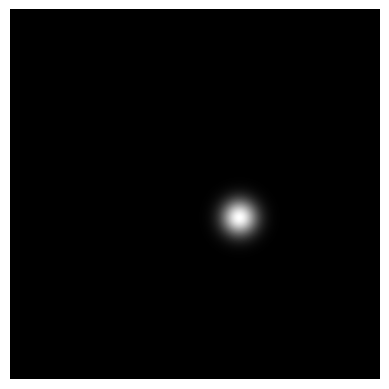

In [13]:
plt.imshow(pixel_map_slice, cmap='gray')
plt.axis('off')

In [14]:
# Convert numpy array to cv2 image
def convert_to_cv2(img):
	img = img.astype(np.uint8)
	img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
	return img

In [15]:
org_img_slice_cv2 = ((org_img_slice - org_img_slice.min()) / (org_img_slice.max() - org_img_slice.min()) * 255.0).astype(np.uint8)
org_img_slice_cv2 = convert_to_cv2(org_img_slice_cv2)
pixel_map_slice_cv2 = ((pixel_map_slice - pixel_map_slice.min()) / (pixel_map_slice.max() - pixel_map_slice.min()) * 255.0).astype(np.uint8)
pixel_map_slice_cv2 = convert_to_cv2(pixel_map_slice_cv2) 

(-0.5, 511.5, 511.5, -0.5)

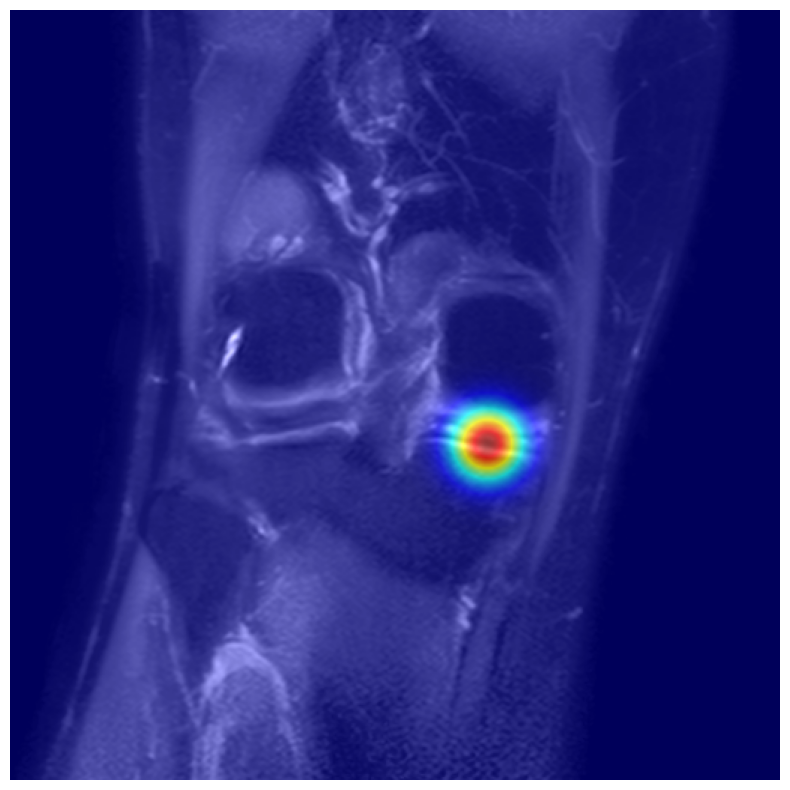

In [16]:
pixel_map_heatmap = cv2.applyColorMap(pixel_map_slice_cv2, cv2.COLORMAP_JET)
super_imposed_img = cv2.addWeighted(pixel_map_heatmap, 0.7, org_img_slice_cv2, 0.9, 0)
super_imposed_img = cv2.cvtColor(super_imposed_img, cv2.COLOR_BGR2RGB)
# make image bigger
plt.figure(figsize=(10, 10))
plt.imshow(super_imposed_img)
plt.axis('off')

In [10]:
import numpy as np
from copy import deepcopy

''' size : size of original 3D numpy matrix A.
    radius : radius of circle inside A which will be filled with ones. 
'''
size, radius = 5, 2

''' A : numpy.ndarray of shape size*size*size. '''
A = np.zeros((size,size, size)) 

''' AA : copy of A (you don't want the original copy of A to be overwritten.) '''
AA = deepcopy(A) 

''' (x0, y0, z0) : coordinates of center of circle inside A. '''
x0, y0, z0 = int(np.floor(A.shape[0]/2)), \
        int(np.floor(A.shape[1]/2)), int(np.floor(A.shape[2]/2))


for x in range(x0-radius, x0+radius+1):
    for y in range(y0-radius, y0+radius+1):
        for z in range(z0-radius, z0+radius+1):
            ''' deb: measures how far a coordinate in A is far from the center. 
                    deb>=0: inside the sphere.
                    deb<0: outside the sphere.'''   
            deb = radius - abs(x0-x) - abs(y0-y) - abs(z0-z) 
            if (deb)>=0: AA[x,y,z] = 1

In [39]:
distance = math.sqrt((8-5)**2+(8-4)**2)
distance

5.0

In [12]:
from monai.networks.nets import UNet
import torch

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)
x = torch.randn(1,1,512,512,32)
model(x).shape

torch.Size([1, 1, 512, 512, 32])